In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import os

## Functions


https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html



## Read all images and find corners

In [2]:
images = glob.glob('./camera_cal/*.jpg')

CHESS_X = 9
CHESS_Y = 6

objp = np.zeros((CHESS_X*CHESS_Y,3), np.float32)
objp[:,:2] = np.mgrid[0:(CHESS_X),0:(CHESS_Y)].T.reshape(-1,2)


objpoints = []
imgpoints = [] 

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (CHESS_X,CHESS_Y), None)
    # If found, add object points, image points 
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (CHESS_X,CHESS_Y), corners, ret)
        cv2.imshow('img', img)
        # wait to look at the image
        cv2.waitKey(500)
cv2.destroyAllWindows()

## Camera Calibration

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [4]:
import pickle

In [5]:
# Store camera calibration

res_dict = dict(ret=ret, mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)

fname = 'calibrationSettings.pk'
outfile = open(fname,'wb')
pickle.dump(res_dict,outfile)
outfile.close()

## Function for performing distrortion correction

Based on functions used in the lessions/quizes

In [6]:
def corners_unwarp(img, nx, ny, mtx, dist):
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # 2) Convert to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # 4) If corners found: 
    if ret:
        tst = cv2.drawChessboardCorners(undist, (nx,ny), corners, ret)
        src = corners[[0,nx-1,-1,-nx],0,:]
        offset = 100
        img_size = (img.shape[1],img.shape[0])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                             [img_size[0]-offset, img_size[1]-offset], 
                             [offset, img_size[1]-offset]])

        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, (undist.shape[1], undist.shape[0]))
    return warped, M

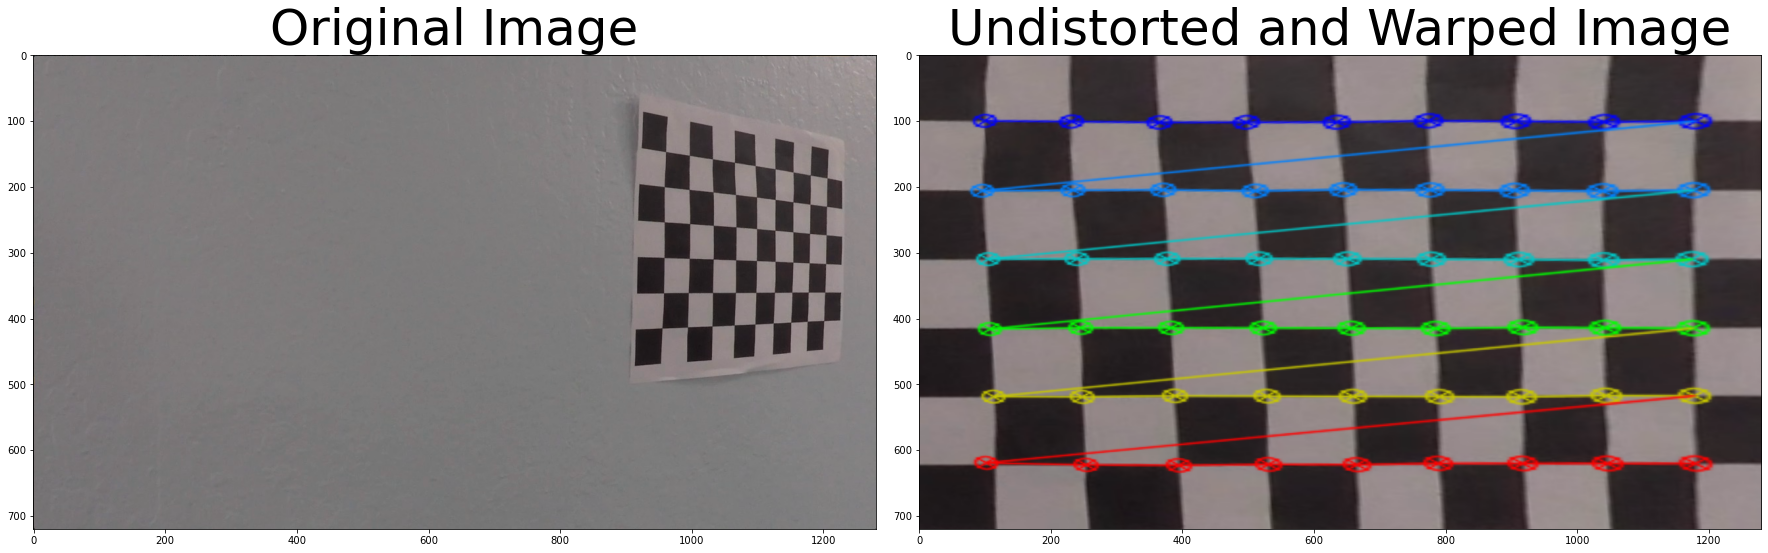

In [7]:
img = cv2.imread(images[5])

top_down, perspective_M = corners_unwarp(img, CHESS_X, CHESS_Y, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

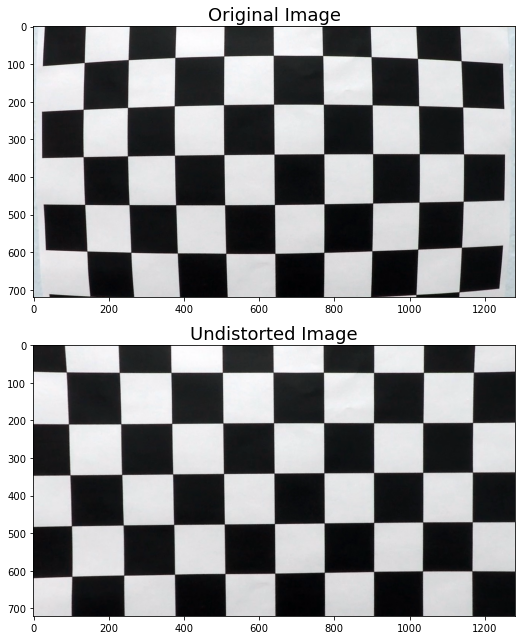

In [27]:
fname2test = images[0]
outfname_base = fname2test.split('\\')[1].split('.')[0]
img = cv2.imread(fname2test)
undist = cv2.undistort(img, mtx, dist, None, mtx)
fig,ax = plt.subplots(nrows=2,figsize=(12,9))
ax[0].imshow(img)
ax[0].set_title('Original Image',fontsize=18)
ax[1].imshow(undist)
ax[1].set_title('Undistorted Image',fontsize=18)


fig.tight_layout()
fig.savefig(f'./output_images/output_{outfname_base}.jpg')



## Apply Distortion Correction on Test Images

In [28]:
from lane_finder.LaneFinder import LaneFinder

ll = LaneFinder(calibration_file='./calibrationSettings.pk', 
                binarization_settings_file='./binarization_settings.json', 
                perspective_settings_file='perspective_settings.json', road_settings_file='./road_settings.json')

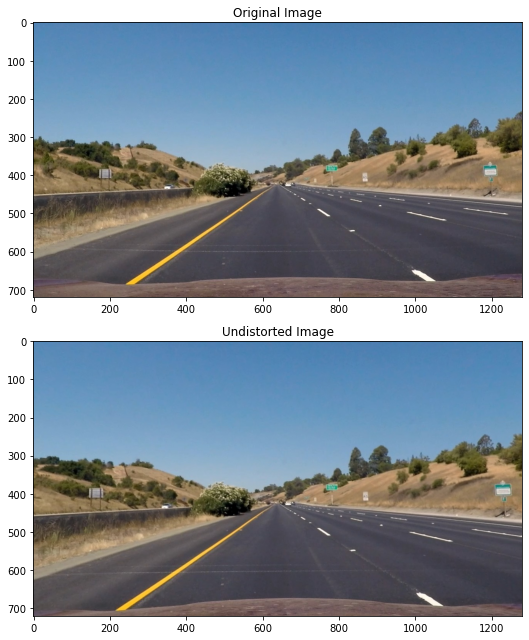

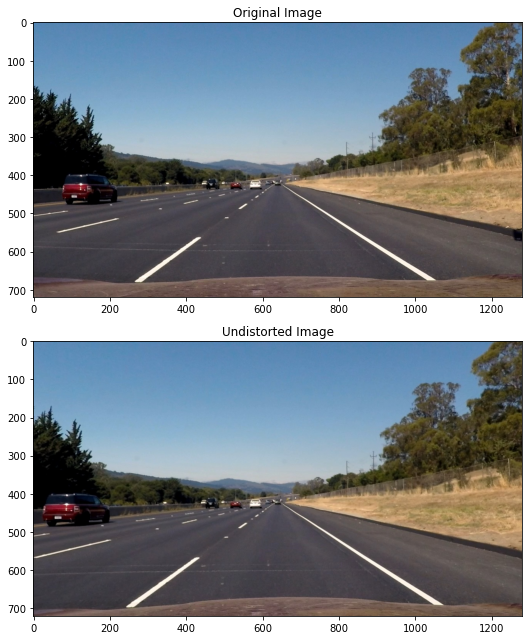

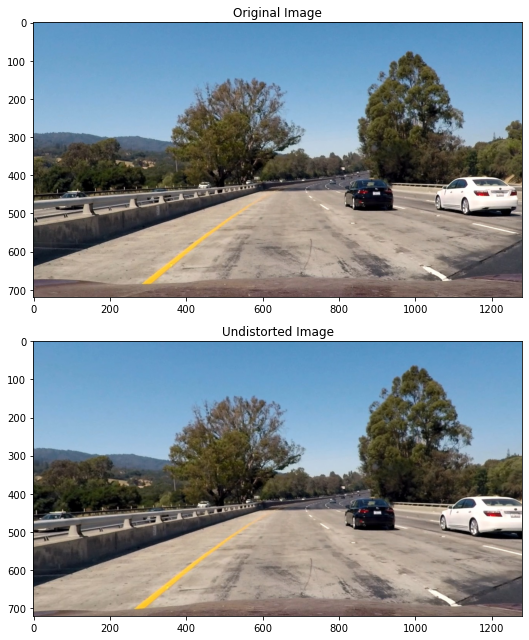

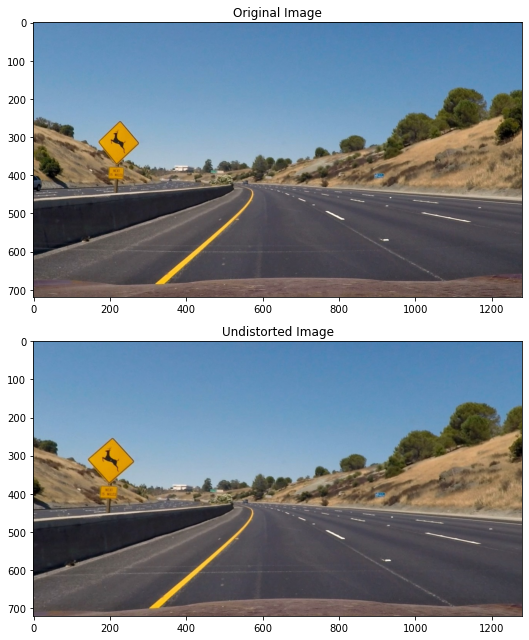

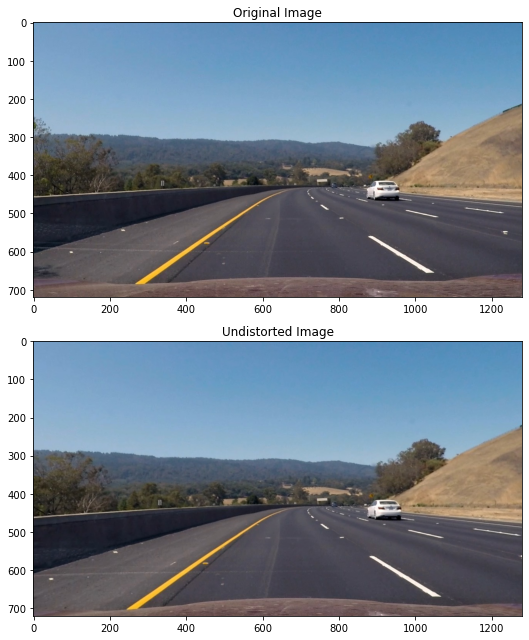

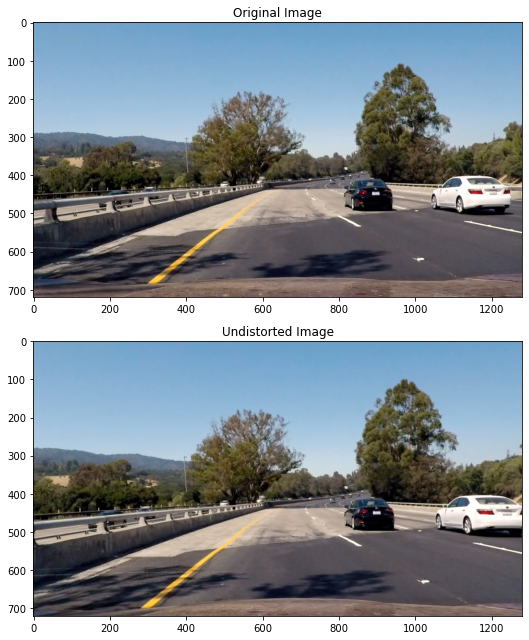

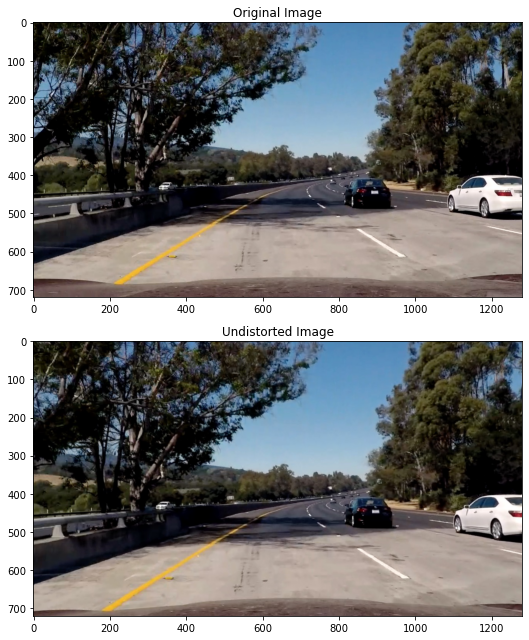

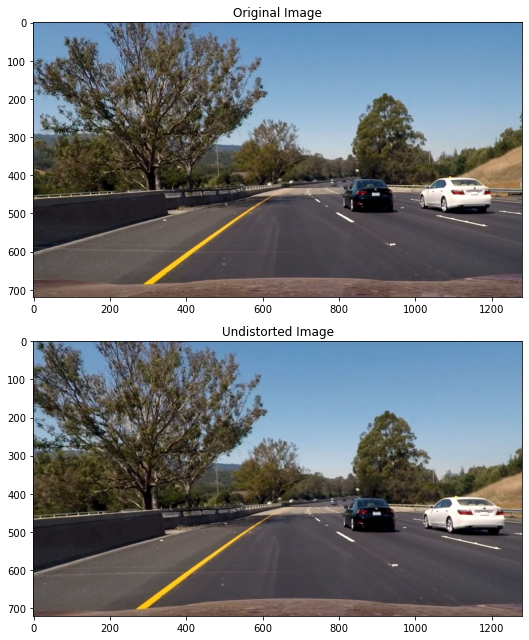

In [31]:
tst_fnames = os.listdir('./test_images/')

for ii,ff in enumerate(tst_fnames):
    img = plt.imread(f'./test_images/{ff}')
    ll.process_frame(img);
    fig, ax = plt.subplots(nrows=2,figsize=(12,9))
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[1].imshow(ll.corrected_image)
    ax[1].set_title('Undistorted Image')
    out_name_base = ff.split('.')[0]
    fig.tight_layout()
    ll.reset_frame()
    fig.savefig(f'./output_images/undistorted_{out_name_base}.jpg')

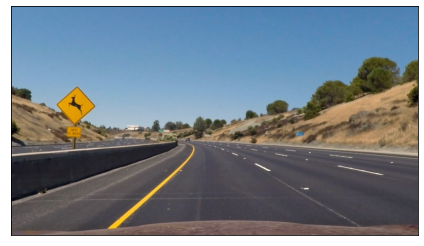

In [26]:
ff = tst_fnames[3]
img = plt.imread(f'./test_images/{ff}')

plt.imshow(cv2.undistort(img,mtx, dist, None, mtx))
out_name_base = ff.split('.')[0]
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig(f'./output_images/single_undistorted_{out_name_base}.jpg')

In [16]:
tst_fnames

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']